# Bitswap success rate

In [3]:
from dateutil import parser
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import math

In [4]:
REFERENCE_TIME = datetime(1970,1,1)

In [5]:
UNAVAILABLE = "unavaiable"
SUCCESS = "success"
FAILURE = "failure"

In [4]:
def parse_time(s):
    if s[-2:] == "ms":
        ms = int(float(s[:-2]))
    elif s[-1] == "s":
        ms = int(1000*float(s[:-1]))
    #return timedelta(milliseconds=ms)
    return ms/1000

In [5]:
# files

data_folder = "data"
ipfs_logs_file = "ipfs.log"
bitswap_logs_file = "bitswap.log"

experiment = "20"

ipfs_logs_path = data_folder + "/" + experiment + "/" + ipfs_logs_file
bitswap_logs_path = data_folder + "/" + experiment + "/" + bitswap_logs_file

In [6]:
f = open(ipfs_logs_path, "r")
ipfs_logs = f.readlines()
f.close()

In [7]:
f = open(bitswap_logs_path, "r")
bitswap_logs = f.readlines()
f.close()

In [8]:
class Fetch:
    def __init__(self, cid, start, npeers):
        self.cid = cid
        self.start = start
        self.npeers = npeers

In [9]:
fetches = []
for line in ipfs_logs:
    sep = line.split(",")
    start = parser.parse(sep[0]) # parse time
    cid = sep[1]
    
    npeers = sep[3]
    fetches.append(Fetch(start, cid, npeers))

In [10]:
len(fetches)

6721

In [11]:
not_found = 0
success = 0
failure = 0
for line in ipfs_logs:
    sep = line.split(",")
    if len(sep[2]) == 0:
        # provider not found
        not_found += 1
    elif '.' in sep[2]:
        # duration = bitswap success
        success += 1
    else:
        # bitswap failure
        failure += 1

In [12]:
print("SUCCESS", success)
print("FAILURE", failure)
print("UNAVAILABLE", not_found)
print("TOTAL", len(ipfs_logs))
print("overall success rate", str(round(100*success/(success+failure), 2))+"%")

SUCCESS 4236
FAILURE 303
UNAVAILABLE 2182
TOTAL 6721
overall success rate 93.32%


In [13]:
logs = {}
for line in ipfs_logs:
    sep = line.split(",")
    log = {}
    cid = sep[1]
    
    log["start"] = parser.parse(sep[0]) # parse time
    log["cid"] = cid
    log["npeers"] = int(sep[3])
    
    if len(sep[2]) == 0:
        log["type"] = UNAVAILABLE
    elif '.' in sep[2]:
        log["type"] = SUCCESS
        log["duration"] = parse_time(sep[2])
    else:
        log["type"] = FAILURE
        log["provider"] = sep[2] # provider found in the dht that provided block via selfish bitswap
        
    logs[cid] = log

In [14]:
for line in bitswap_logs:
    sep = line[:-1].split(",")
    cid = sep[0]
    peerid = sep[1]

    if cid not in logs or len(peerid) == 0:
        continue
    
    if "provider" in logs[cid]:
        print("multiple providers for cid:", cid, "1", logs[cid]["provider"], "2",peerid)
    else:
        logs[cid]["provider"] = peerid

multiple providers for cid: QmXWS2DdaQy8kzr9GU9v3n7JWXgPp4dqfDEsXLYM4713WF 1 12D3KooWGGyvEomXVi5YHqXdfGHx1GKHjVrUo313pWCs5uSfkoHK 2 12D3KooWGGyvEomXVi5YHqXdfGHx1GKHjVrUo313pWCs5uSfkoHK
multiple providers for cid: Qmbr2ejnq3VGD1knyfweZY46PEVEwULtzTt3ude6Sff17Z 1 12D3KooWBszbJcQut3gW8CYPNgXsECiiRCMGm17xUb4Lr2iKQZEh 2 Qmbut9Ywz9YEDrz8ySBSgWyJk41Uvm2QJPhwDJzJyGFsD6


In [15]:
bitswap_provider_score = {}
for cid in logs:
    if logs[cid]["type"] == SUCCESS:
        if "provider" not in logs[cid]:
            print(cid)
            continue
        if logs[cid]["provider"] not in bitswap_provider_score:
            bitswap_provider_score[logs[cid]["provider"]] = 1
        else:
            bitswap_provider_score[logs[cid]["provider"]] += 1

In [16]:
# order the list
bitswap_provider_score = {key: val for key, val in sorted(bitswap_provider_score.items(), key = lambda ele: ele[1], reverse = True)}

In [17]:
bitswap_provider_score

{'12D3KooWGtRcWvihm4hX2gT6bQu3uyjb78rgyQR3hPhkxMwivscY': 553,
 '12D3KooWLsSWaRsoCejZ6RMsGqdftpKbohczNqs3jvNfPgRwrMp2': 268,
 '12D3KooWNy2SmgY384B9EHVHdbSkvXEADwxjzd4ejXQqicxWpxxT': 200,
 '12D3KooWJc7GbwkjVg9voPNxdRnmEDS3i8NXNwRXD6kLattaMnE4': 188,
 '12D3KooWGRJo1vLDBtfS8a4cVss2QVqvbCaPgtmwwgpUtW675QRa': 180,
 '12D3KooWJ59N9z5CyLTtcUTnuTKnRTEVxiztijiEAYbP16aZjQ3D': 172,
 '12D3KooWAuBxG5uMBkeyFwHD9JyHaJGTqn7NhJbmmukNDPHSLKts': 166,
 '12D3KooWL5rvBiZBE9NDWYfbCGSTfQpbScQPxDTfutLbVBjUot9R': 158,
 '12D3KooWKKcYZGRtQVdZVrTuARdJHLSBymB7dNN1R6PWwUT24qK4': 81,
 '12D3KooWLSMVRxtFrRWofS6MjysgWnPh7iiFEGYeEAeBQceNrf4G': 78,
 '12D3KooWE8L7kAi4wTVcnSVgmHRxykpYX24Ck9toAifA9Dn2Q4Rw': 64,
 '12D3KooWGGyvEomXVi5YHqXdfGHx1GKHjVrUo313pWCs5uSfkoHK': 61,
 '12D3KooWBszbJcQut3gW8CYPNgXsECiiRCMGm17xUb4Lr2iKQZEh': 55,
 '12D3KooWPzJxqGQWfaNqR9ft66e5c6NoBhDezXogLHeJQgD62Gvf': 53,
 'QmY7JB6MQXhxHvq7dBDh4HpbH29v4yE9JRadAVpndvzySN': 52,
 '12D3KooWADEseR47whZxWrsmZMubonArpgCqtKdsth5orYHsvWjD': 36,
 '12D3KooWC9L4RjPGgqpz

In [18]:
print(len(bitswap_provider_score), "providers in total")

381 providers in total


In [19]:
top_n_peers_vals = [1, 3, 5, 10, 20, 50, int(len(bitswap_provider_score)/2), len(bitswap_provider_score)]
for n in top_n_peers_vals:
    s = 0
    c = 0
    for peerid in bitswap_provider_score:
        if c == n:
            break
        c += 1
        s += bitswap_provider_score[peerid]
    print("Top", n, "peers serve", round(100*s/success,2), "% of the successful bitswap requests")

Top 1 peers serve 13.05 % of the successful bitswap requests
Top 3 peers serve 24.1 % of the successful bitswap requests
Top 5 peers serve 32.79 % of the successful bitswap requests
Top 10 peers serve 48.25 % of the successful bitswap requests
Top 20 peers serve 58.99 % of the successful bitswap requests
Top 50 peers serve 71.08 % of the successful bitswap requests
Top 190 peers serve 92.75 % of the successful bitswap requests
Top 381 peers serve 100.0 % of the successful bitswap requests


In [20]:
dht_provider_score = {}
dht_cids_count = 0
for cid in logs:
    if logs[cid]["type"] == FAILURE:
        if "provider" not in logs[cid]:
            print(cid)
            continue
        dht_cids_count += 1
        if logs[cid]["provider"] not in dht_provider_score:
            dht_provider_score[logs[cid]["provider"]] = 1
        else:
            dht_provider_score[logs[cid]["provider"]] += 1

In [21]:
dht_provider_score = {key: val for key, val in sorted(dht_provider_score.items(), key = lambda ele: ele[1], reverse = True)}

In [22]:
print(dht_cids_count, "cids served by", len(dht_provider_score), "peers through the dht")

303 cids served by 42 peers through the dht


In [23]:
dht_provider_score

{'12D3KooWBszbJcQut3gW8CYPNgXsECiiRCMGm17xUb4Lr2iKQZEh': 37,
 '12D3KooWGRJo1vLDBtfS8a4cVss2QVqvbCaPgtmwwgpUtW675QRa': 29,
 '12D3KooWCPjVv1qZEy8twPUK9fzEvNSF3JxY7zwAFGzybsm2J2cP': 27,
 '12D3KooWJc7GbwkjVg9voPNxdRnmEDS3i8NXNwRXD6kLattaMnE4': 19,
 '12D3KooWAuBxG5uMBkeyFwHD9JyHaJGTqn7NhJbmmukNDPHSLKts': 18,
 '12D3KooWBeb4VBQ7mfYEmLKkjcgvtfo6hZHCtyWdR2p8YeWFYD8P': 16,
 '12D3KooWLsSWaRsoCejZ6RMsGqdftpKbohczNqs3jvNfPgRwrMp2': 16,
 '12D3KooWHXKaRAKgQbPNqgpJwojmcHUajSFnQvHdKjPRbVHRhobC': 16,
 '12D3KooWKd92H37a8gCDZPDAAGTYvEGAq7CNk1TcaCkcZedkTwFG': 16,
 '12D3KooWKKcYZGRtQVdZVrTuARdJHLSBymB7dNN1R6PWwUT24qK4': 16,
 '12D3KooWE8L7kAi4wTVcnSVgmHRxykpYX24Ck9toAifA9Dn2Q4Rw': 12,
 '12D3KooWGGyvEomXVi5YHqXdfGHx1GKHjVrUo313pWCs5uSfkoHK': 10,
 '12D3KooWDLYiAdzUdM7iJHhWu5KjmCN62aWd7brQEQGRWbv8QcVb': 7,
 '12D3KooWJ59N9z5CyLTtcUTnuTKnRTEVxiztijiEAYbP16aZjQ3D': 7,
 '12D3KooWDRak1XzURGh9MvGR4EWaP9kcbmdoagAcGMcNxBXXLzTF': 7,
 '12D3KooWC9L4RjPGgqpzBUBkcVpKjJYofCkC5i5QdQftg1LdsFb2': 5,
 '12D3KooWCMMw5BKA5XHDJiuFit

In [24]:
top_n_peers_vals = [1, 3, 5, 10, int(len(dht_provider_score)/2), len(dht_provider_score)]
for n in top_n_peers_vals:
    s = 0
    c = 0
    for peerid in dht_provider_score:
        if c == n:
            break
        c += 1
        s += dht_provider_score[peerid]
    print("Top", n, "peers serve", round(100*s/failure,2), "% of the content discovered by the DHT")

Top 1 peers serve 12.21 % of the content discovered by the DHT
Top 3 peers serve 30.69 % of the content discovered by the DHT
Top 5 peers serve 42.9 % of the content discovered by the DHT
Top 10 peers serve 69.31 % of the content discovered by the DHT
Top 21 peers serve 91.75 % of the content discovered by the DHT
Top 42 peers serve 100.0 % of the content discovered by the DHT


## Bitswap time distribution

In [25]:
success_time_distrib = []
for cid in logs:
    if logs[cid]["type"] == SUCCESS:
        success_time_distrib.append(logs[cid]["duration"])

In [26]:
success_time_distrib

[0.781,
 1.31,
 1.601,
 1.921,
 2.784,
 3.079,
 4.043,
 4.26,
 4.748,
 0.575,
 1.074,
 1.344,
 1.455,
 13.114,
 0.596,
 2.558,
 0.274,
 9.772,
 0.574,
 4.627,
 0.448,
 0.192,
 1.264,
 0.202,
 1.592,
 0.491,
 0.382,
 1.075,
 1.534,
 0.983,
 3.712,
 0.215,
 0.614,
 0.929,
 0.849,
 7.579,
 0.649,
 0.615,
 0.997,
 0.167,
 1.213,
 0.376,
 2.566,
 0.483,
 3.163,
 1.873,
 0.45,
 1.851,
 0.412,
 1.814,
 2.02,
 1.71,
 1.917,
 1.445,
 1.486,
 1.766,
 3.503,
 1.91,
 4.475,
 0.327,
 2.011,
 4.322,
 4.504,
 6.646,
 0.863,
 0.359,
 1.978,
 0.578,
 0.766,
 0.736,
 0.309,
 1.019,
 1.092,
 1.232,
 4.065,
 0.56,
 3.351,
 0.62,
 1.876,
 1.236,
 0.426,
 1.81,
 0.25,
 1.453,
 0.424,
 0.877,
 0.482,
 0.878,
 1.739,
 0.21,
 0.368,
 0.508,
 0.167,
 0.342,
 0.365,
 1.091,
 1.762,
 0.606,
 1.118,
 0.401,
 0.116,
 0.105,
 0.467,
 0.253,
 0.47,
 0.483,
 0.122,
 0.279,
 0.594,
 0.084,
 0.7,
 0.467,
 0.488,
 0.83,
 1.557,
 0.88,
 0.183,
 0.296,
 0.286,
 0.436,
 0.199,
 11.792,
 0.448,
 0.218,
 0.876,
 0.24,
 0.384,

In [27]:
# probably overcomplicated, but makes nice graphs =)
mul = 1000
def density_plot(data, scale, normalize=None, title=None, xaxis=None, yaxis=None, filename=None):
    m = mul*(scale[-1]-scale[0])/50
    
    # add last empty column to pad last thick
    data.append(0)
    # normalize if needed
    if normalize is not None:
        data = [x/normalize for x in data]
    # makes 10 ticks on the plot
    #major_ticks = [int(1000*scale[i]) if i%(len(scale)//10) == 0 else "" for i in range(len(data))]
    major_ticks = [int(mul*scale[i]) for i in range(len(data)) if i%(len(scale)//10) == 0]
    
    plt.rc('font', size=20)
    
    # set fig style
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
            
    #plt.bar([x+0.1 for x in range(len(data))], data, width=0.8, align='edge')
    plt.bar([mul*s+1 for s in scale], data, width=0.8*m, align='edge')
    
    ax.set_xticks(major_ticks)
    ax.set_xticks([mul*s for s in scale], minor=True)

    #plt.xticks(range(len(data)), major_ticks)
#    plt.xticks(range(len(data)), major_ticks, minor=True)
    
    plt.grid()
    
    if xaxis is not None:
        plt.xlabel(xaxis)
    if yaxis is not None:
        plt.ylabel(yaxis)
    if title is not None:
        plt.title(title)
        
    plt.text(mul*scale[-1], 0.95*max(data), "Samples: "+str(normalize), ha='right')

    if filename is not None:
        plt.savefig('plots/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')
    
    plt.show()


In [28]:
mul = 1000
def zoom_distribution(data, start, end, nbuckets):
    buckets_per_second = nbuckets/(end-start)
    buckets = [0]*nbuckets
    for t in data:
        if start <= t < end:
            i = math.floor((t-start)*buckets_per_second) # floor to the closest lower bucket
            buckets[i]+=1
    return buckets, [x/mul for x in range(int(mul*start), int(mul*end)+1, int(mul*(end-start)/nbuckets))]

In [29]:
def make_plot(data, start, end, nbuckets, title=None, xaxis=None, yaxis=None, filename=None):
    zoomed, scale = zoom_distribution(data, start, end, nbuckets)
    density_plot(zoomed, scale, normalize=len(data), title=title, xaxis=xaxis, yaxis=yaxis, filename=filename)

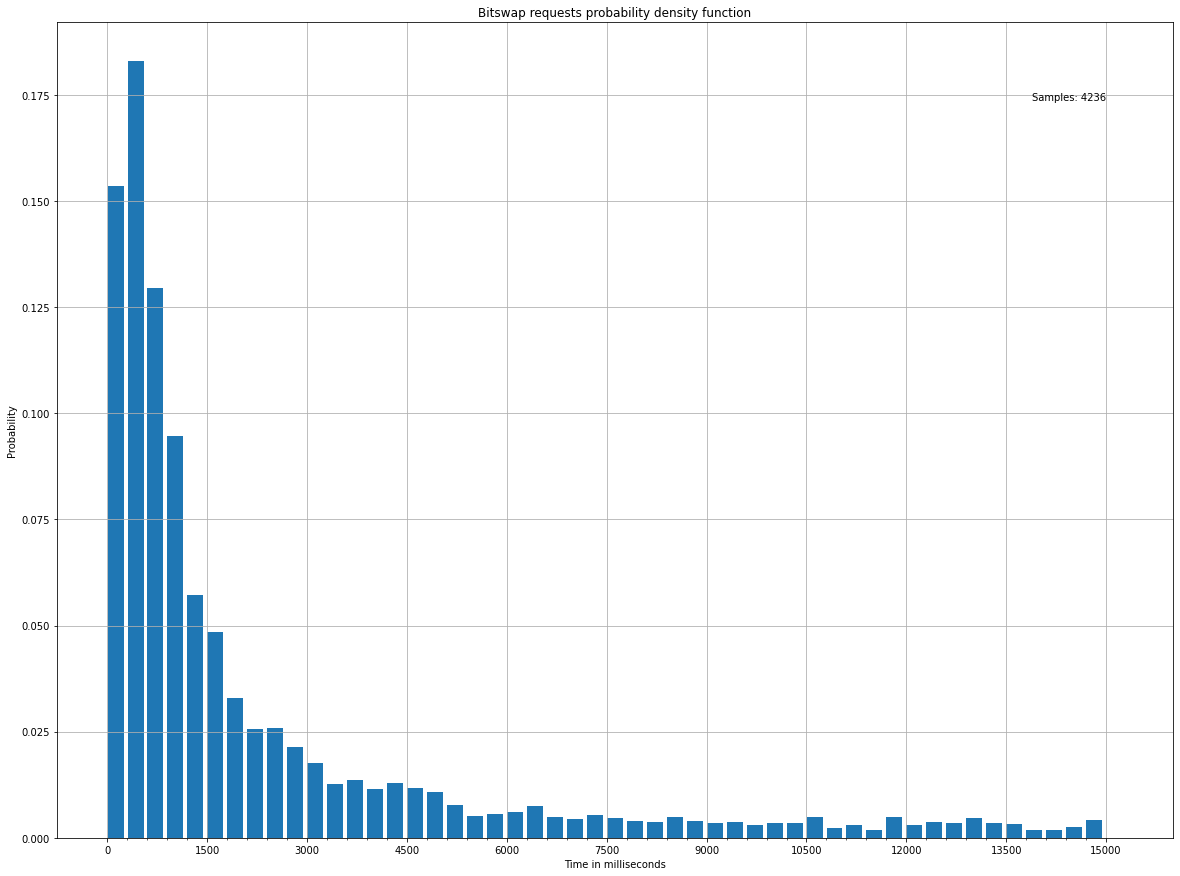

In [30]:
make_plot(success_time_distrib, 0, 15, 50, title="Bitswap requests probability density function", xaxis="Time in milliseconds", yaxis="Probability")

In [31]:
def bin_plot(data, n_bins=50, start=None, end=None, additional=False, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # data is a list of values
    # n_bins is the number of bins to display
    # start is the first bin on the xaxis (left)
    # end is the last bin on the yaxis (right)
    # additional=True adds a last bin (making the result visually more pleasant)
    
    # define start and end
    if start is None:
        start = min(data)
    if end is None:
        end = max(data)
    
    # define interval between each bin
    interval = (end-start) / n_bins

    # add the additional last bin
    if additional:
        end += interval
        n_bins += 1
        
    # generate the bins
    bins = [0 for _ in range(n_bins)] # create n_bins bins

    # iterate on data and classify it into the bins
    for d in data:
        if start <= d < end:
            b = int((d-start)/interval)
            bins[b] += 1
        elif d == end:
            # corner case, if some value IS the end, round it to the previous bin
            bins[-1] += 1
    
    # xaxis scale
    xs = [start + i*interval for i in range(n_bins)]
    
    # width of each bar
    width = 0.8 * interval
    
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    
    # bar plot the data
    plt.bar(xs, bins, width=width)
    
    # set the grid
    plt.grid()
    
    # samples occupies ~ 1/5 of the space
    samples_ypos = max(bins)/2
    # if a bin among the last 1/5 of the x space is higher than 1/2 max(bin)
    # raise the samples_ypos to 110% of this value
    if max(bins[-int(n_bins/5):]) > samples_ypos:
        samples_ypos = max(bins[-int(n_bins/5):])*1.1
    plt.text(0.95*end, samples_ypos, "Samples: "+str(sum(bins)), ha='right')
    
    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    
    # export to file
    if filename is not None:
        plt.savefig('plots/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()
    

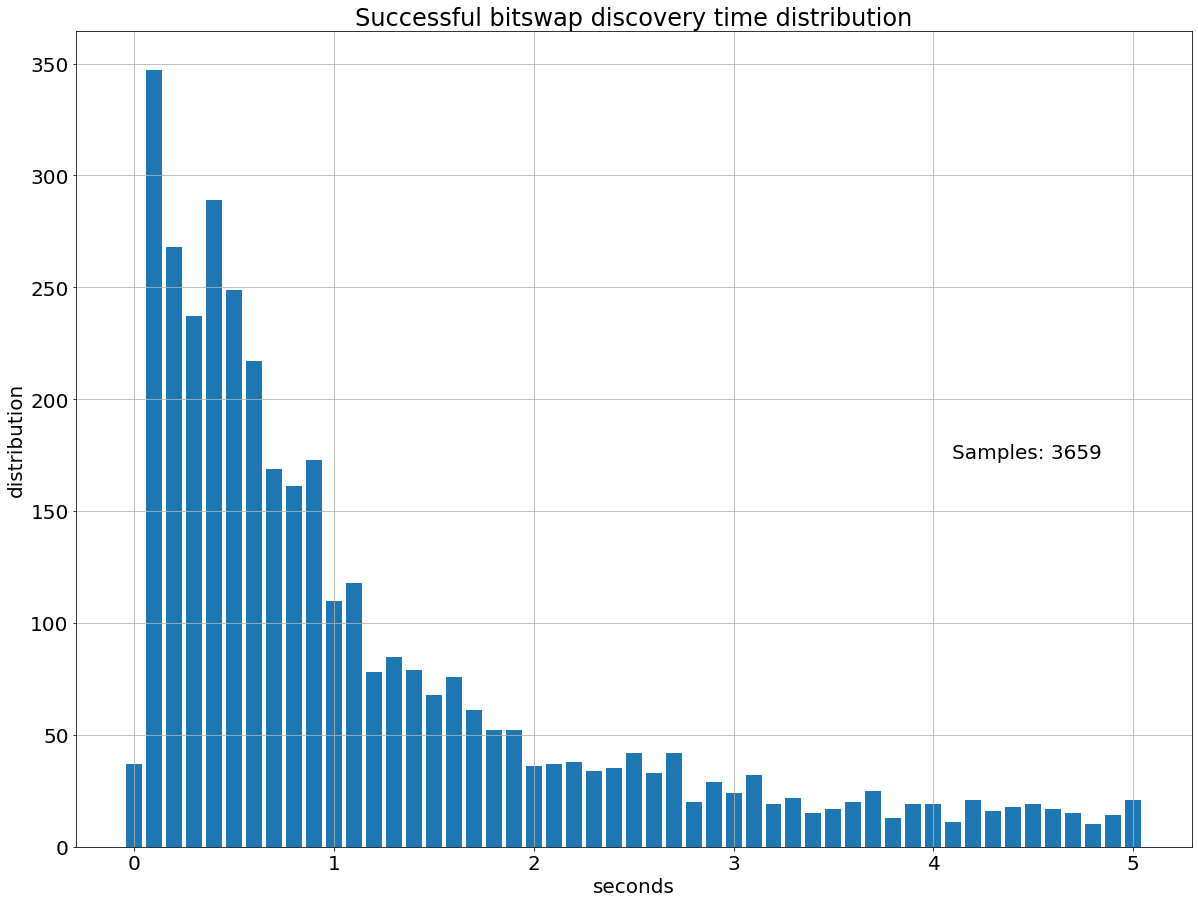

In [32]:
bin_plot(success_time_distrib, start=0, end=5, n_bins=50, additional=True, title="Successful bitswap discovery time distribution", xaxis_label="seconds", yaxis_label="distribution")


## Success rate over time

In [33]:
# Get min and max times recorded for the experiment
min_time = datetime(year=2100, month=1, day=1)
max_time = datetime(year=1970, month=1, day=1)
for cid in logs:
    if logs[cid]['type'] in [SUCCESS, FAILURE]:
        if logs[cid]["start"].timestamp() > max_time.timestamp():
            max_time = logs[cid]["start"]
        if logs[cid]["start"].timestamp() < min_time.timestamp():
            min_time = logs[cid]["start"]

In [34]:
n_bins_time = 200
time_interval = (max_time - min_time)/n_bins_time

In [35]:
time_interval

datetime.timedelta(seconds=31, microseconds=879280)

In [36]:
bins_time = [{SUCCESS: 0, FAILURE: 0} for _ in range(n_bins_time)]
bins_conns_time = [[] for _ in range(n_bins_time)]
for cid in logs:
    b = int((logs[cid]['start']-min_time) / time_interval)
    if b >= n_bins_time:
        b = n_bins_time - 1
        
    if logs[cid]['type'] is SUCCESS:
        bins_time[b][SUCCESS] += 1
    elif logs[cid]['type'] is FAILURE:
        bins_time[b][FAILURE] += 1
        
    if logs[cid]['type'] in [SUCCESS, FAILURE]:
        bins_conns_time[b].append(logs[cid]['npeers'])

In [37]:
success_rate_time = []
for m in bins_time:
    success_rate_time.append(m[SUCCESS]/(m[SUCCESS] + m[FAILURE]))

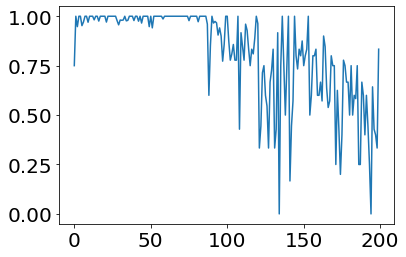

In [38]:
plt.plot(success_rate_time)

In [39]:
npeers_over_time = []
for m in bins_conns_time:
    npeers_over_time.append(sum(m)/len(m))

## Number of open connections over time

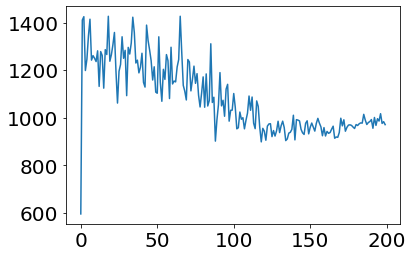

In [40]:
plt.plot(npeers_over_time)

In [41]:
def boxplot_time(data, hours=None, n_bins=None, start=None, end=None, additional=False, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # data is a list of tuples [value(time), value]
    # n_bins is the number of bins to display
    # start is the first bin on the xaxis (left)
    # end is the last bin on the yaxis (right)
    # additional=True adds a last bin (making the result visually more pleasant)
    
    # TODO
    # range of bins (e.g 20-50)
    # given this range, and the difference between start and end, define a number of bins
    # fitting an integer number of hours, close to end, and drop the last part
    # This allow us to have "round" numbers of the plots, adjusting according to the
    # experiment duration
    
    times = [x[0] for x in data]
    
    # define start and end
    if start is None:
        start = min(times)
    if end is None:
        end = max(times)
            
    # define interval between each bin
    interval = (end-start) / n_bins

    # add the additional last bin
    if additional:
        end += interval
        n_bins += 1
        
    # generate the bins
    bins = [[] for _ in range(n_bins)] # create n_bins bins

    # iterate on data and classify it into the bins
    for d in data:
        if start <= d[0] < end:
            b = int((d[0]-start)/interval)
            bins[b].append(d[1])
        elif d[0] == end:
            # corner case, if some value IS the end, round it to the previous bin
            bins[-1].append(d[1])
    
    # xaxis scale
    xs = [int(i*interval) for i in range(n_bins)]
    
    # width of each bar
    width = 0.8 * interval
    
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    
    # bar plot the data
    #plt.bar(xs, bins, width=width)
    ax.boxplot(bins, widths=width, positions=xs)
        
    # set the grid
    plt.grid()
    
    # samples occupies ~ 1/5 of the space
    #samples_ypos = max(bins)/2
    # if a bin among the last 1/5 of the x space is higher than 1/2 max(bin)
    # raise the samples_ypos to 110% of this value
    #if max(bins[-int(n_bins/5):]) > samples_ypos:
    #    samples_ypos = max(bins[-int(n_bins/5):])*1.1
    #plt.text(0.95*end, samples_ypos, "Samples: "+str(sum(bins)), ha='right')
    
    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    
    # export to file
    if filename is not None:
        plt.savefig('plots/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()


In [42]:
time_npeers = []
for cid in logs:
    if logs[cid]['type'] in [SUCCESS, FAILURE]:
        time_npeers.append((logs[cid]['start'].timestamp(), logs[cid]['npeers']))

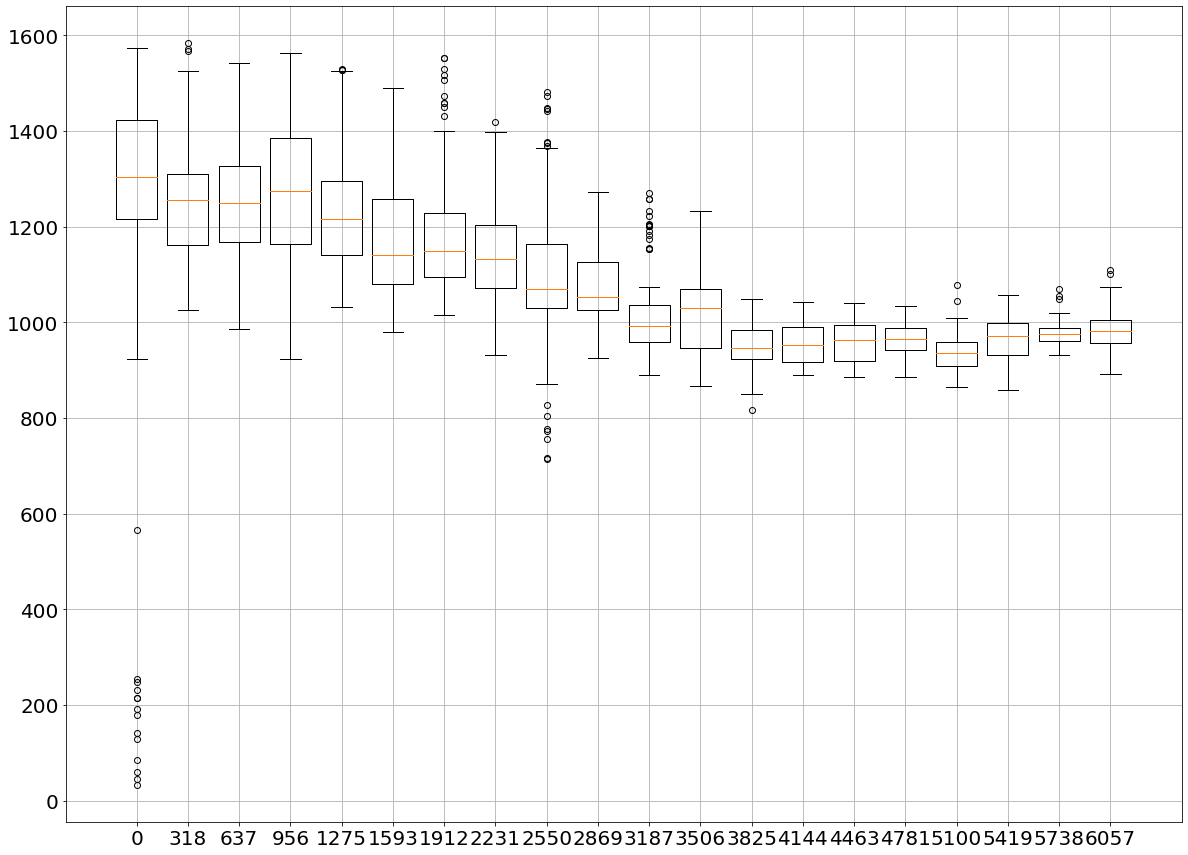

In [43]:
boxplot_time(time_npeers, n_bins=20)

In [44]:
min_conn = 100000
max_conn = 0
for cid in logs:
    if logs[cid]['type'] in [SUCCESS, FAILURE]:
        if logs[cid]['npeers'] < min_conn:
            min_conn = logs[cid]['npeers']
        if logs[cid]['npeers'] > max_conn:
            max_conn = logs[cid]['npeers']

## Success rate vs number of connections

In [45]:
print(min_conn, max_conn)

33 1583
